In [1]:
import pandas as pd
import re 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [2]:
#Define the local 
abc_loc = './data/D1D_abc_feed_output.csv'
swish_loc = './data/D1D_swish_feed_output.csv'

# Load the datasets
swish = pd.read_csv(swish_loc)
abc = pd.read_csv(abc_loc)

In [3]:
#Swish outputs only a single FLAG_ID in the details field
def extract_flag_id_swish(details):
    match = re.search(r'ABC_FLAG_ID=(\d+)', details)
    return match.group(1) if match else None 

def extract_flag_id_abc(details):
    # Find all numbers inside ABC_FLAG_IDS brackets
    matches = re.findall(r'ABC_FLAG_IDS=\[([^\]]+)\]', details)
    if matches:
        # Split by space and return as a list of IDs (strip spaces)
        return [id_.strip() for id_ in re.findall(r'\d+', matches[0])]
    else:
        return None

def extract_layer(details):
    """
    Extracts the value of 'LAYER' from a details string.

    Parameters
    ----------
    details : str
        The details string containing 'LAYER='.

    Returns
    -------
    str or None
        The extracted layer value, or None if not found.
    """
    match = re.search(r'LAYER=([^,]+)', details)
    return match.group(1) if match else None
    
def explode_flag_ids(df, flag_id_col='FLAG_ID'):
    """
    Expands rows in a DataFrame where the specified flag ID column contains a list of IDs.

    For each row, if the flag ID column contains a list, this function creates a separate row for each ID,
    keeping all other columns unchanged. Rows with a single flag ID remain unchanged.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the flag ID column.
    flag_id_col : str, optional
        The name of the column containing flag IDs (default is 'FLAG_ID').

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row contains only a single flag ID, with other columns duplicated as needed.
    """
    # Ensure FLAG_ID is a list for all rows
    df[flag_id_col] = df[flag_id_col].apply(lambda x: x if isinstance(x, list) else [x])
    # Explode the FLAG_ID column so each FLAG_ID gets its own row
    exploded_df = df.explode(flag_id_col)
    return exploded_df

In [4]:
swish.head()

,entity,feed_value,details,data_last_update,fab
0,GTA453,0.656317,"DEVICE=*,LAYER=8BM5FC_FTL_DENSE,OPERATION=2349...",2025-08-08,D1D
1,VFN430,0.534942,"DEVICE=*,LAYER=8ZRO_FTL_PREGOOP,OPERATION=2022...",2025-08-08,D1D
2,NST550,0.776802,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=255974,ABC_F...",2025-08-08,D1D
3,KST420,0.999513,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=226446,ABC_F...",2025-08-08,D1D
4,NST438,0.668805,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=188660,ABC_F...",2025-08-08,D1D


In [5]:
abc.head()

,entity,feed_value,details,data_last_update,fab
0,LAT402_PM2,0.061029,"PROCESS=1278,ABC_FLAG_IDS=[1237671],OPERATIONS...",2025-08-04 12:09:22,D1D
1,NST402,0.092111,"PROCESS=1278,ABC_FLAG_IDS=[1237979],OPERATIONS...",2025-08-07 20:44:02,D1D
2,TBF441,0.159328,"PROCESS=1278,ABC_FLAG_IDS=[1237980],OPERATIONS...",2025-08-07 20:18:32,D1D
3,PGX404_PM1,0.141622,"PROCESS=1278,ABC_FLAG_IDS=[1238197],OPERATIONS...",2025-08-07 16:51:46,D1D
4,EPF591,0.025168,"PROCESS=1278,ABC_FLAG_IDS=[1248642],OPERATIONS...",2025-08-06 10:33:29,D1D


# Preprocessing: 
- Extracting `FLAG_ID` and `LAYER_ID` from `details` field.
- Standardizing date format
- Renaming features before merging

In [6]:
#Extract FLAG_IDs from the details columns
swish['FLAG_ID'] = swish['details'].apply(extract_flag_id_swish)

# Extract the layer from the details column
swish['LAYER_ID'] = swish['details'].apply(extract_layer)

# Extract FLAG_IDs from the details columns for ABC
abc['FLAG_ID'] = abc['details'].apply(extract_flag_id_abc)
# Explode the FLAG_IDs in the ABC DataFrame given that the FLAG_IDs can contain multiple IDs
# (e.g., ABC_FLAG_IDS=[123, 456])
abc = explode_flag_ids(abc)

#Rename columns to help distinguish between the two datasets once joined
swish = swish.rename(columns={
    'feed_value': 'feed_value_swish',
    'details': 'details_swish',
    'data_last_update': 'data_last_update_swish'
})

abc = abc.rename( columns={
    'feed_value': 'feed_value_abc',
    'details': 'details_abc',
    'data_last_update': 'data_last_update_abc'
})

#Converting to date time and standardizing the date format
swish['data_last_update_swish'] = pd.to_datetime(swish['data_last_update_swish']).dt.strftime('%m/%d/%Y')
abc['data_last_update_abc'] = pd.to_datetime(abc['data_last_update_abc']).dt.strftime('%m/%d/%Y')


# Processing:
- Inner Join on: `FLAG_ID`, `entity`, `fab`
- Defining `feed_value_diff` = `feed_value_swish` - `feed_value_abc`

In [7]:
#Perform an inner join on the FLAG_ID, entity, and fab columns
FLAG_ID_inner_join = swish.merge(
    abc,
    on=['FLAG_ID', 'entity', 'fab'],
    how='inner'
)

# Defining feed_value_diff as the difference between the two feed values
FLAG_ID_inner_join['feed_value_diff'] =  FLAG_ID_inner_join['feed_value_swish'] - FLAG_ID_inner_join['feed_value_abc']

#Sort the df by 'feed_value_diff' in ascendingo rder 
inner_join_sorted = FLAG_ID_inner_join.sort_values(by='feed_value_diff', ascending=True)

# Reorder the columns to allow for easier comparison
df = inner_join_sorted[[
    'entity',
    'fab',
    'FLAG_ID',
    'LAYER_ID',
    'data_last_update_swish',
    'data_last_update_abc',
    'details_swish',
    'details_abc',
    'feed_value_swish',
    'feed_value_abc',
    'feed_value_diff'
]]



# Table sorted by `feed_value_diff` in an ascending order

### 5 Observations with LOWEST feed value difference

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df.head()

,entity,fab,FLAG_ID,LAYER_ID,data_last_update_swish,data_last_update_abc,details_swish,details_abc,feed_value_swish,feed_value_abc,feed_value_diff
0,KCD416,D1D,1281763,8PLYPSTOXHM_HVF,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=25327...","PROCESS=1278,ABC_FLAG_IDS=[1281763 1281766 128...",0.531329,0.744369,-0.213040
1,JGR402,D1D,1281764,8PLYPSTOXHM_HVF,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=20110...","PROCESS=1278,ABC_FLAG_IDS=[1281764 1281767 128...",0.619792,0.793135,-0.173343
30,PAT524_PM3,D1D,1281820,8PYREM,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8PYREM,OPERATION=210952,ABC_FLA...","PROCESS=1278,ABC_FLAG_IDS=[1281820 1281829 128...",0.638518,0.770876,-0.132358
32,KCD408,D1D,1281822,8PYREM,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8PYREM,OPERATION=247701,ABC_FLA...","PROCESS=1278,ABC_FLAG_IDS=[1281822 1281831 128...",0.798898,0.864834,-0.065936
2,SPA432,D1D,1281765,8PLYPSTOXHM_HVF,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=24332...","PROCESS=1278,ABC_FLAG_IDS=[1281765 1281768 128...",0.919345,0.886044,0.033301


### 5 Observations with HIGHEST feed value difference

In [9]:
df.tail()

,entity,fab,FLAG_ID,LAYER_ID,data_last_update_swish,data_last_update_abc,details_swish,details_abc,feed_value_swish,feed_value_abc,feed_value_diff
39,PGX402,D1D,1281838,8STLTREM1_FTL,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8STLTREM1_FTL,OPERATION=251263,...","PROCESS=1278,ABC_FLAG_IDS=[1281838],OPERATIONS...",0.994446,0.230223,0.764223
40,FTL414,D1D,1281839,8STLTREM1_FTL,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8STLTREM1_FTL,OPERATION=214155,...","PROCESS=1278,ABC_FLAG_IDS=[1281839],OPERATIONS...",0.999627,0.216919,0.782708
48,GTA404_PM5,D1D,1281905,8VCG_FTL,08/08/2025,08/07/2025,"DEVICE=*,LAYER=8VCG_FTL,OPERATION=254617,ABC_F...","PROCESS=1278,ABC_FLAG_IDS=[1281905],OPERATIONS...",1.000000,0.175589,0.824411
38,NCD406,D1D,1281837,8STLTREM1_FTL,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8STLTREM1_FTL,OPERATION=254145,...","PROCESS=1278,ABC_FLAG_IDS=[1281837],OPERATIONS...",0.989080,0.125119,0.863961
37,SPK412,D1D,1281836,8STLTREM1_FTL,08/08/2025,08/08/2025,"DEVICE=*,LAYER=8STLTREM1_FTL,OPERATION=207026,...","PROCESS=1278,ABC_FLAG_IDS=[1281836],OPERATIONS...",0.978923,0.085379,0.893544


### The range of SWISH feed values is from 0.531 to 0.9999999600716786.

In [10]:
min_val = df['feed_value_swish'].min()
max_val = df['feed_value_swish'].max()
print(f"The range of SWISH feed values is from {min_val:.3f} to {max_val}.")

The range of SWISH feed values is from 0.531 to 0.9999999600716786.


### The range of ABC feed values is from 0.083441 to 0.886044.

In [11]:
min_val_abc = df['feed_value_abc'].min()
max_val_abc = df['feed_value_abc'].max()
print(f"The range of ABC feed values is from {min_val_abc} to {max_val_abc}.")

The range of ABC feed values is from 0.083441 to 0.886044.


## Feed Values Distribution: Swish vs ABC

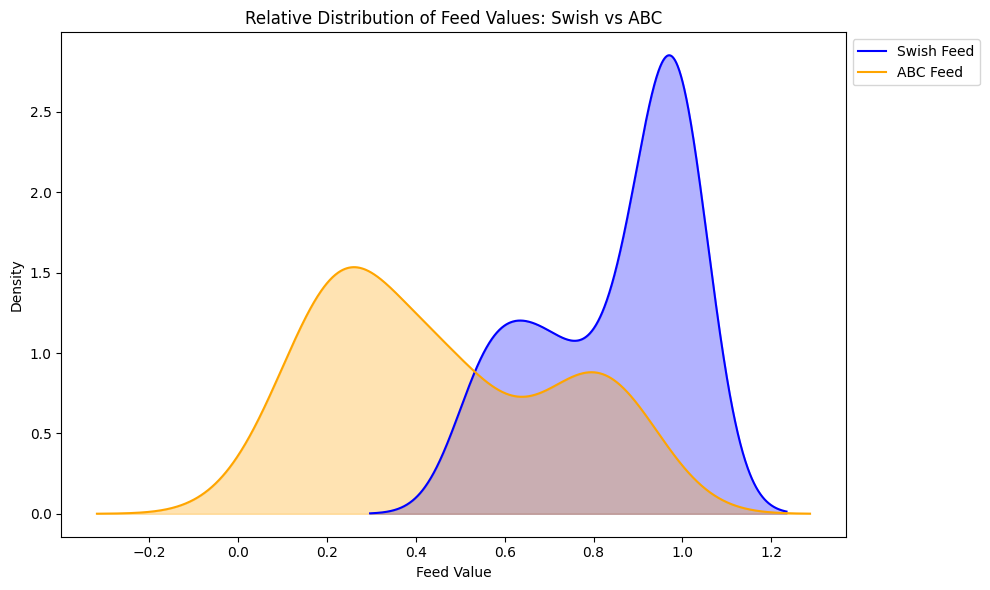

In [12]:
plt.figure(figsize=(10, 6))
ax = df['feed_value_swish'].plot(kind='kde', label='Swish Feed', color='blue')
df['feed_value_abc'].plot(kind='kde', label='ABC Feed', color='orange', ax=ax)

#Filling the area under the curves
x_swish = ax.get_lines()[0].get_xdata() 
y_swish = ax.get_lines()[0].get_ydata()
ax.fill_between(x_swish, y_swish, color='blue', alpha=0.3)

x_abc = ax.get_lines()[1].get_xdata()
y_abc = ax.get_lines()[1].get_ydata()
ax.fill_between(x_abc, y_abc, color='orange', alpha=0.3)

plt.xlabel('Feed Value')
plt.ylabel('Density')
# plt.title('Kernel Density Estimate: Swish Feed vs ABC Feed (Filled)')
plt.title('Relative Distribution of Feed Values: Swish vs ABC')

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


# Feed Values Overlayed: Sorted by `feed_value_diff` in an Ascending order

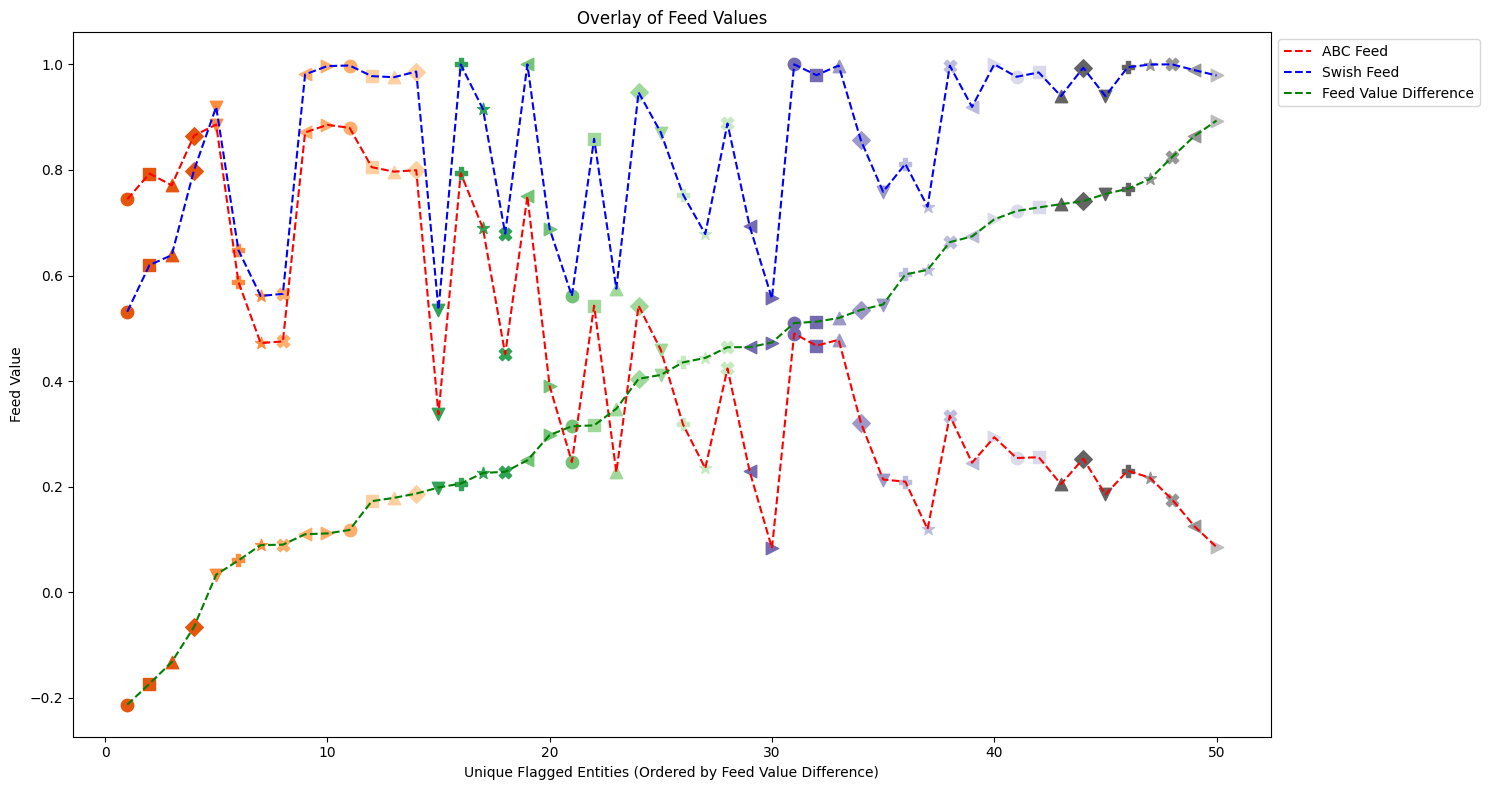

In [13]:
plt.figure(figsize=(15, 8))

# Create a range for the x-axis based on the number of rows in the DataFrame
x = range(1, len(df)+1)
width = 1.5  # Width of the lines
size = 80

# Use a single color palette for all data points (e.g., 'tab20c')
palette = cm.get_cmap('tab20c')(np.linspace(0.2, 0.9, len(df)))

# Define a list of marker shapes to cycle through
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
marker_list = [markers[i % len(markers)] for i in range(len(df))]

plt.plot(x, df['feed_value_abc'], label='ABC Feed', color='red', linewidth=width, linestyle='--')
for i in range(len(df)):
    plt.scatter(x[i], df['feed_value_abc'].iloc[i], color=palette[i], s=size, marker=marker_list[i])

plt.plot(x, df['feed_value_swish'], label='Swish Feed', color='blue', linewidth=width, linestyle='--')
for i in range(len(df)):
    plt.scatter(x[i], df['feed_value_swish'].iloc[i], color=palette[i], s=size, marker=marker_list[i])

plt.plot(x, df['feed_value_diff'], label='Feed Value Difference', color='green', linewidth=width, linestyle='--')
for i in range(len(df)):
    plt.scatter(x[i], df['feed_value_diff'].iloc[i], color=palette[i], s=size, marker=marker_list[i])

plt.xlabel('Unique Flagged Entities (Ordered by Feed Value Difference)')
plt.ylabel('Feed Value')
plt.title('Overlay of Feed Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Boxplot: Feed Value Difference by LAYER_ID

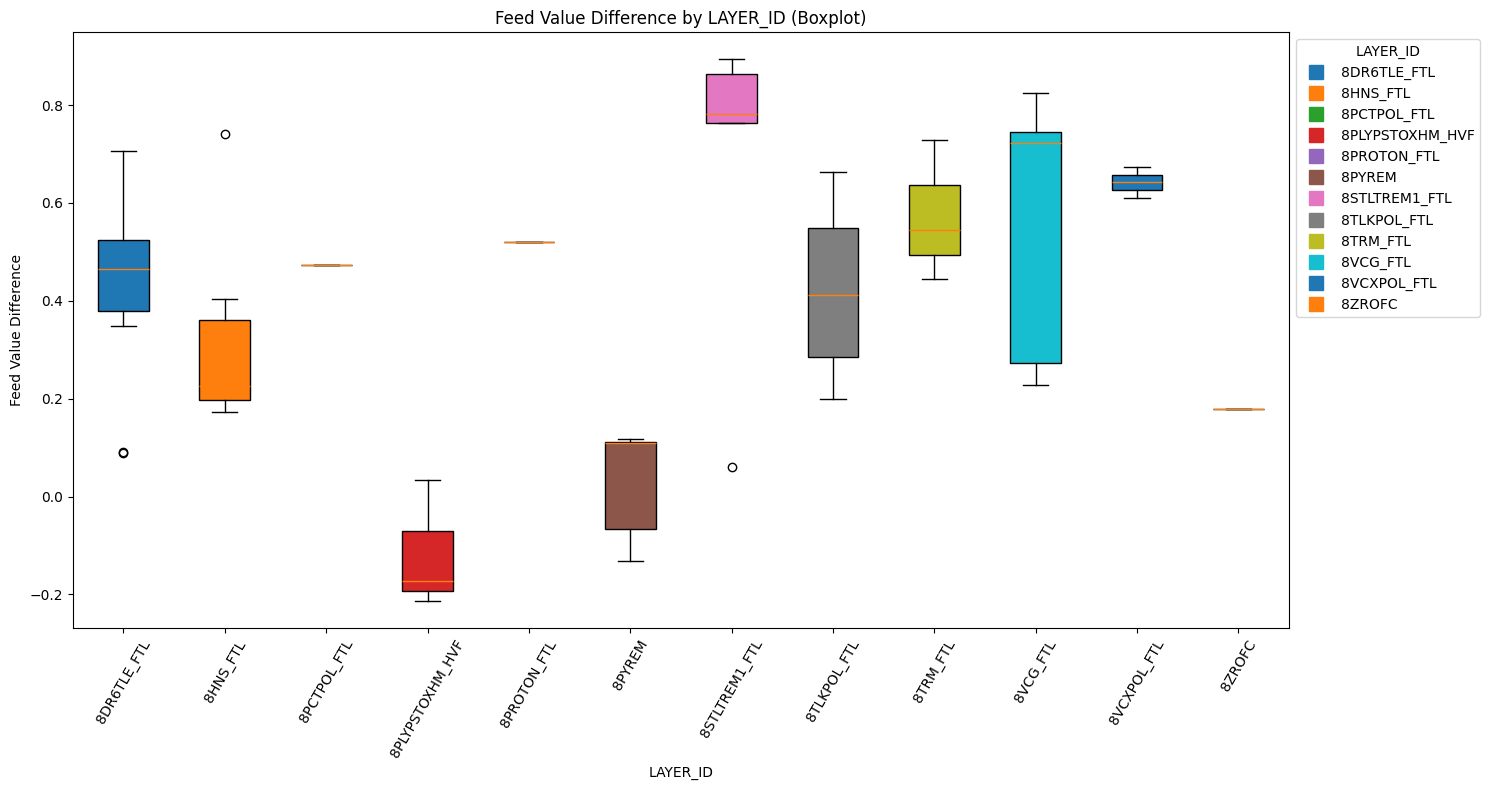

In [14]:
plt.figure(figsize=(15, 8))

# Prepare data for boxplot
layer_order = sorted(df['LAYER_ID'].unique())
data = [df[df['LAYER_ID'] == layer]['feed_value_diff'] for layer in layer_order]

# Boxplot
box = plt.boxplot(data, patch_artist=True, labels=layer_order)

# Color each box according to the color scheme
colors = plt.cm.tab10.colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Create legend handles for each layer
import matplotlib.lines as mlines
legend_handles = [
    mlines.Line2D([], [], color=colors[i % len(colors)], marker='s', linestyle='None',
                  markersize=10, label=str(layer))
    for i, layer in enumerate(layer_order)
]

plt.xlabel('LAYER_ID')
plt.ylabel('Feed Value Difference')
plt.title('Feed Value Difference by LAYER_ID (Boxplot)')
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), title='LAYER_ID')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

# Count of unique entities in Swish and ABC

### - `50` Unique entities present `both in SWISH and ABC` dataset
### - `8` Unique entites `only present in SWISH` dataset but not in ABC dataset
### - `38` Unique entities `only present in ABC` dataset but not in SWISH dataset. 

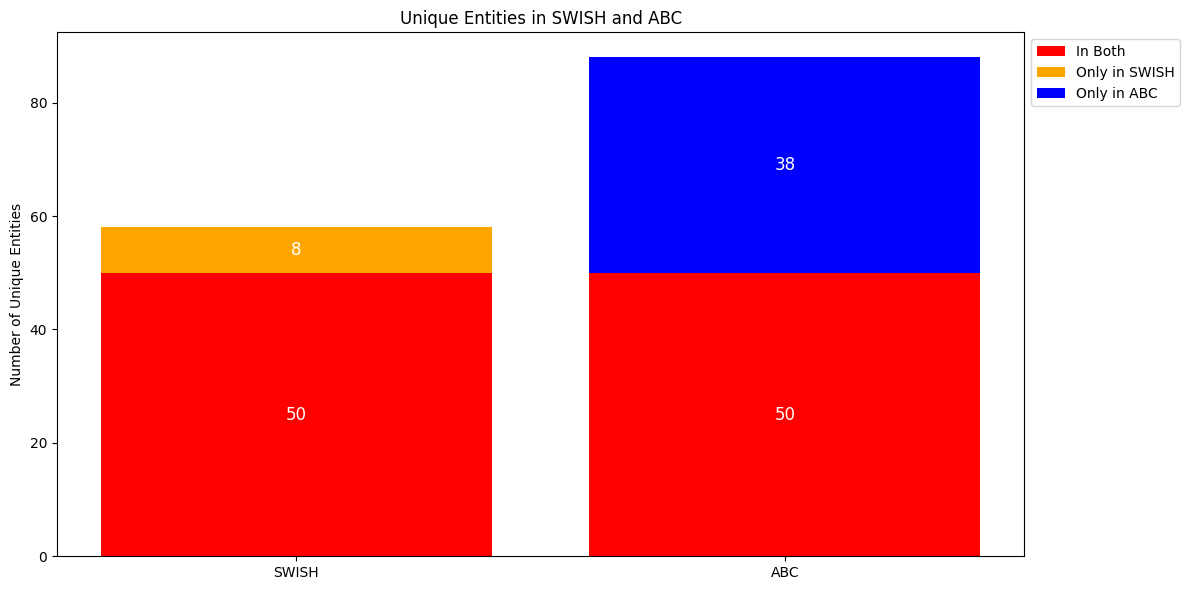

In [15]:
        

# Get sets of unique entities
swish_entities = set(swish['entity'].unique())
abc_entities = set(abc['entity'].unique())

# Calculate intersections and differences
both = swish_entities & abc_entities
swish_only = swish_entities - abc_entities
abc_only = abc_entities - swish_entities

# Counts
n_both = len(both)
n_swish_only = len(swish_only)
n_abc_only = len(abc_only)

# Data for stacked bar chart (red at the bottom)
swish_counts = [n_both, n_swish_only]
abc_counts = [n_both, n_abc_only]

labels = ['SWISH', 'ABC']
colors = [['red', 'orange'], ['red', 'blue']]

plt.figure(figsize=(12, 6)) 

# SWISH bar
swish_bar_both = plt.bar(labels[0], swish_counts[0], color=colors[0][0])
swish_bar_only = plt.bar(labels[0], swish_counts[1], bottom=swish_counts[0], color=colors[0][1])

# ABC bar
abc_bar_both = plt.bar(labels[1], abc_counts[0], color=colors[1][0])
abc_bar_only = plt.bar(labels[1], abc_counts[1], bottom=abc_counts[0], color=colors[1][1])

# Add counts on top of each segment
plt.text(0, swish_counts[0]/2, str(n_both), ha='center', va='center', color='white', fontsize=12)
plt.text(0, swish_counts[0]+swish_counts[1]/2, str(n_swish_only), ha='center', va='center', color='white', fontsize=12)
plt.text(1, abc_counts[0]/2, str(n_both), ha='center', va='center', color='white', fontsize=12)
plt.text(1, abc_counts[0]+abc_counts[1]/2, str(n_abc_only), ha='center', va='center', color='white', fontsize=12)

# Custom legend handles for correct color mapping
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='red', label='In Both'),
    Patch(facecolor='orange', label='Only in SWISH'),
    Patch(facecolor='blue', label='Only in ABC')
]

plt.ylabel('Number of Unique Entities')
plt.title('Unique Entities in SWISH and ABC')
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [16]:
# Extract entities only in SWISH
only_swish_entities = swish_only
only_swish = swish[swish['entity'].isin(only_swish_entities)].copy()


# Extract entities only in ABC
only_abc_entities = abc_only
only_abc = abc[abc['entity'].isin(only_abc_entities)].copy()

## Save the extracted entities to CSV files
# only_swish.to_csv('./output/only_swish_entities.csv', index=False)
# only_abc.to_csv('./output/only_abc_entities.csv', index=False)

# Distribution of Feed Values: Entities Only Present in Swish vs Only Present in ABC

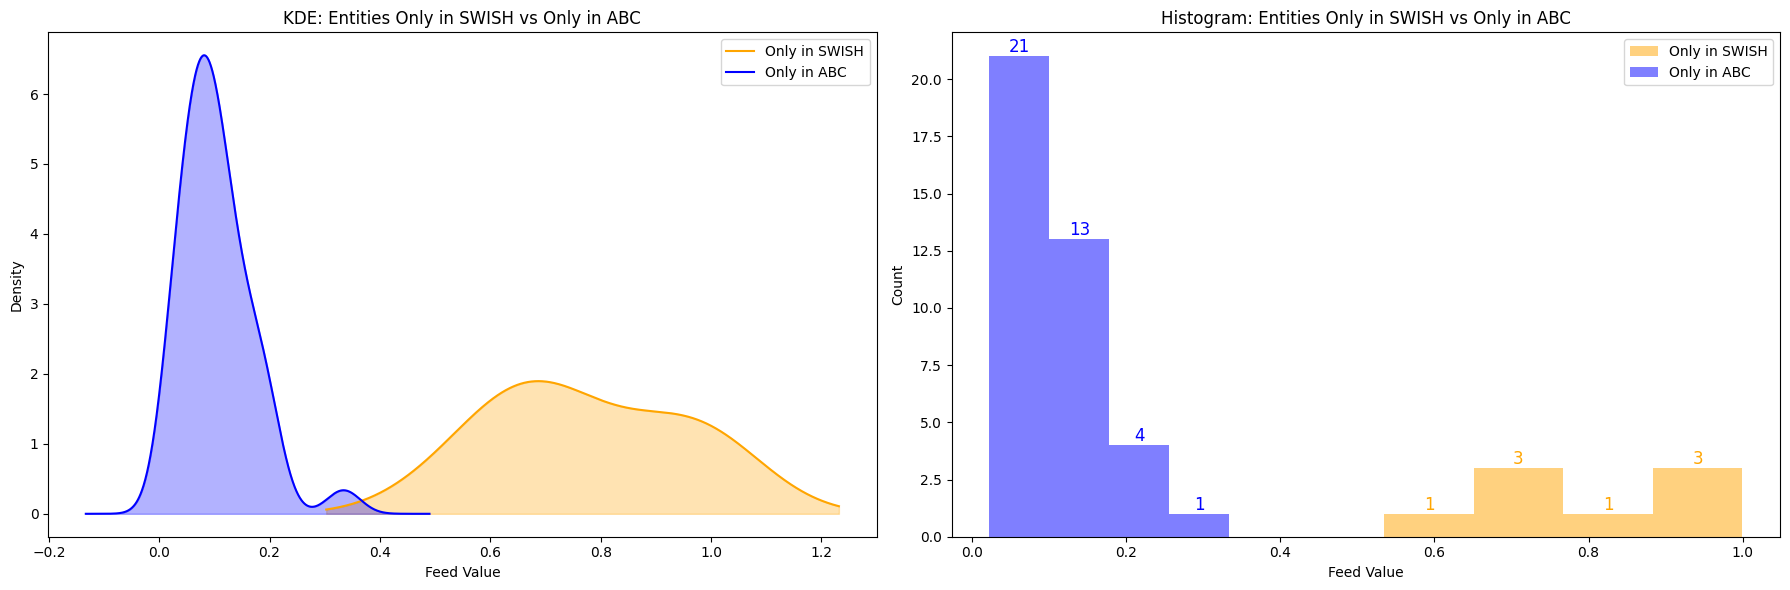

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- KDE subplot ---
ax_kde = axes[0]
if not only_swish.empty:
    only_swish['feed_value_swish'].plot(kind='kde', label='Only in SWISH', color='orange', ax=ax_kde)
    x_swish = ax_kde.get_lines()[-1].get_xdata()
    y_swish = ax_kde.get_lines()[-1].get_ydata()
    ax_kde.fill_between(x_swish, y_swish, color='orange', alpha=0.3)
if not only_abc.empty:
    only_abc['feed_value_abc'].plot(kind='kde', label='Only in ABC', color='blue', ax=ax_kde)
    x_abc = ax_kde.get_lines()[-1].get_xdata()
    y_abc = ax_kde.get_lines()[-1].get_ydata()
    ax_kde.fill_between(x_abc, y_abc, color='blue', alpha=0.3)
ax_kde.set_xlabel('Feed Value')
ax_kde.set_ylabel('Density')
ax_kde.set_title('KDE: Entities Only in SWISH vs Only in ABC')
ax_kde.legend()

# --- Histogram subplot ---
ax_hist = axes[1]
bins = 4
if not only_swish.empty:
    counts_swish, bins_swish, patches_swish = ax_hist.hist(
        only_swish['feed_value_swish'], bins=bins, alpha=0.5, label='Only in SWISH', color='orange', density=False
    )
    for count, left, right in zip(counts_swish, bins_swish[:-1], bins_swish[1:]):
        ax_hist.text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', color='orange', fontsize=12)
if not only_abc.empty:
    counts_abc, bins_abc, patches_abc = ax_hist.hist(
        only_abc['feed_value_abc'], bins=bins, alpha=0.5, label='Only in ABC', color='blue', density=False
    )
    for count, left, right in zip(counts_abc, bins_abc[:-1], bins_abc[1:]):
        ax_hist.text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', color='blue', fontsize=12)
ax_hist.set_xlabel('Feed Value')
ax_hist.set_ylabel('Count')
ax_hist.set_title('Histogram: Entities Only in SWISH vs Only in ABC')
ax_hist.legend()

plt.tight_layout()
plt.show()

# Distribution of Feed Values: All Entites in Swish vs Only Present in ABC

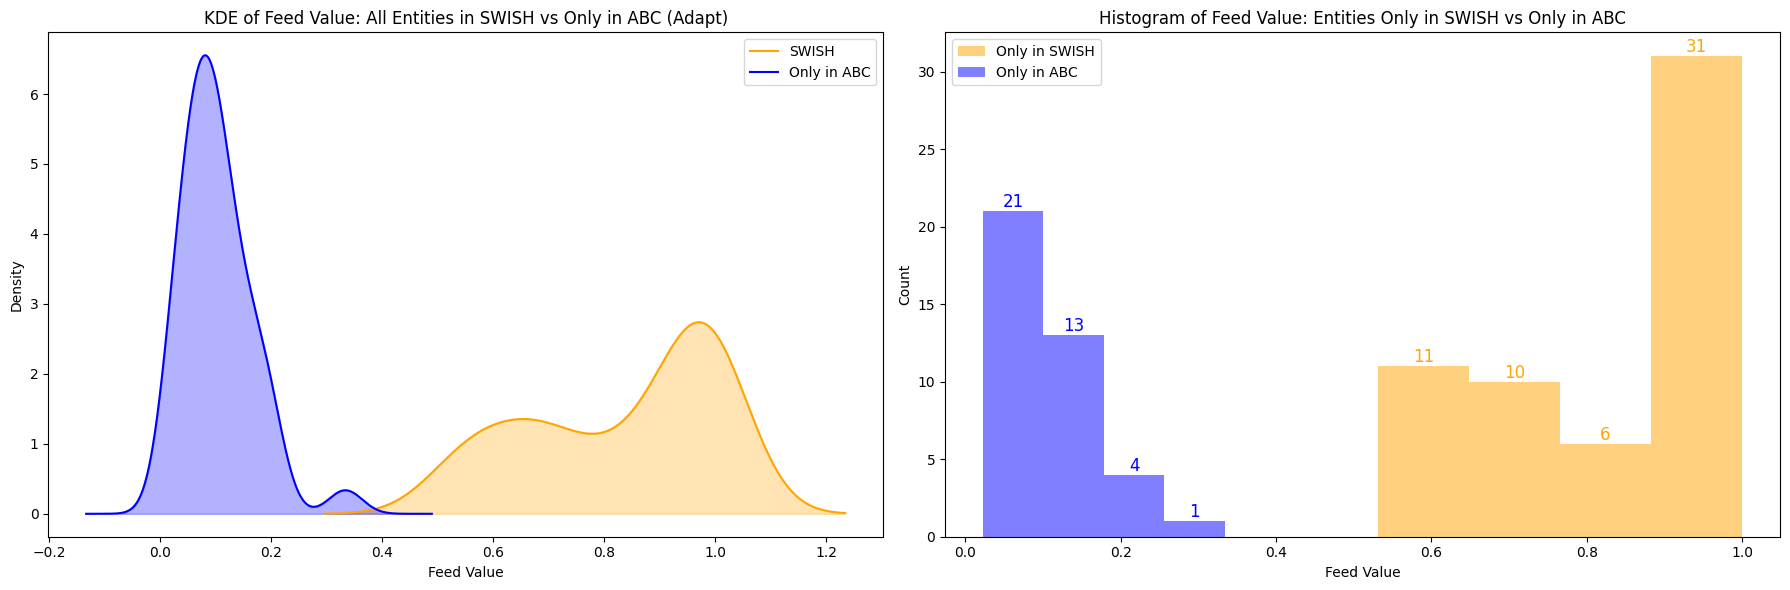

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- KDE subplot ---
ax_kde = axes[0]
if not swish.empty:
    swish['feed_value_swish'].plot(kind='kde', label='SWISH', color='orange', ax=ax_kde)
    x_swish = ax_kde.get_lines()[-1].get_xdata()
    y_swish = ax_kde.get_lines()[-1].get_ydata()
    ax_kde.fill_between(x_swish, y_swish, color='orange', alpha=0.3)
if not only_abc.empty:
    only_abc['feed_value_abc'].plot(kind='kde', label='Only in ABC', color='blue', ax=ax_kde)
    x_abc = ax_kde.get_lines()[-1].get_xdata()
    y_abc = ax_kde.get_lines()[-1].get_ydata()
    ax_kde.fill_between(x_abc, y_abc, color='blue', alpha=0.3)
ax_kde.set_xlabel('Feed Value')
ax_kde.set_ylabel('Density')
ax_kde.set_title('KDE of Feed Value: All Entities in SWISH vs Only in ABC (Adapt)')
ax_kde.legend()

# --- Histogram subplot ---
ax_hist = axes[1]
bins = 4
if not swish.empty:
    counts_swish, bins_swish, patches_swish = ax_hist.hist(
        swish['feed_value_swish'], bins=bins, alpha=0.5, label='Only in SWISH', color='orange', density=False
    )
    for count, left, right in zip(counts_swish, bins_swish[:-1], bins_swish[1:]):
        ax_hist.text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', color='orange', fontsize=12)
if not only_abc.empty:
    counts_abc, bins_abc, patches_abc = ax_hist.hist(
        only_abc['feed_value_abc'], bins=bins, alpha=0.5, label='Only in ABC', color='blue', density=False
    )
    for count, left, right in zip(counts_abc, bins_abc[:-1], bins_abc[1:]):
        ax_hist.text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', color='blue', fontsize=12)
ax_hist.set_xlabel('Feed Value')
ax_hist.set_ylabel('Count')
ax_hist.set_title('Histogram of Feed Value: Entities Only in SWISH vs Only in ABC')
ax_hist.legend()

plt.tight_layout()
plt.show()

# The 8 SWISH observations excluded from ABC

### By comparing with the 50 observations:
- No matching LAYER_ID: 
    - 8BM5FC_FTL_DENSE
    - 8ZRO_FTL_PREGOOP
    - 8M5CP_PLANAR
- Matching LAYER_ID: 
    - 8PROTON_FTL
    - 8TLKPOL_FTL

In [19]:
only_swish

,entity,feed_value_swish,details_swish,data_last_update_swish,fab,FLAG_ID,LAYER_ID
0,GTA453,0.656317,"DEVICE=*,LAYER=8BM5FC_FTL_DENSE,OPERATION=2349...",08/08/2025,D1D,1281638,8BM5FC_FTL_DENSE
1,VFN430,0.534942,"DEVICE=*,LAYER=8ZRO_FTL_PREGOOP,OPERATION=2022...",08/08/2025,D1D,1281639,8ZRO_FTL_PREGOOP
2,NST550,0.776802,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=255974,ABC_F...",08/08/2025,D1D,1281654,8DVDN_MG
3,KST420,0.999513,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=226446,ABC_F...",08/08/2025,D1D,1281655,8DVDN_MG
4,NST438,0.668805,"DEVICE=*,LAYER=8DVDN_MG,OPERATION=188660,ABC_F...",08/08/2025,D1D,1281656,8DVDN_MG
12,KST498,0.994258,"DEVICE=*,LAYER=8PROTON_FTL,OPERATION=210944,AB...",08/08/2025,D1D,1281785,8PROTON_FTL
17,PAT524_PM1,0.899167,"DEVICE=*,LAYER=8TLKPOL_FTL,OPERATION=265186,AB...",08/08/2025,D1D,1281792,8TLKPOL_FTL
44,DRT402,0.679441,"DEVICE=*,LAYER=8M5CP_PLANAR,OPERATION=173542,A...",08/08/2025,D1D,1281827,8M5CP_PLANAR


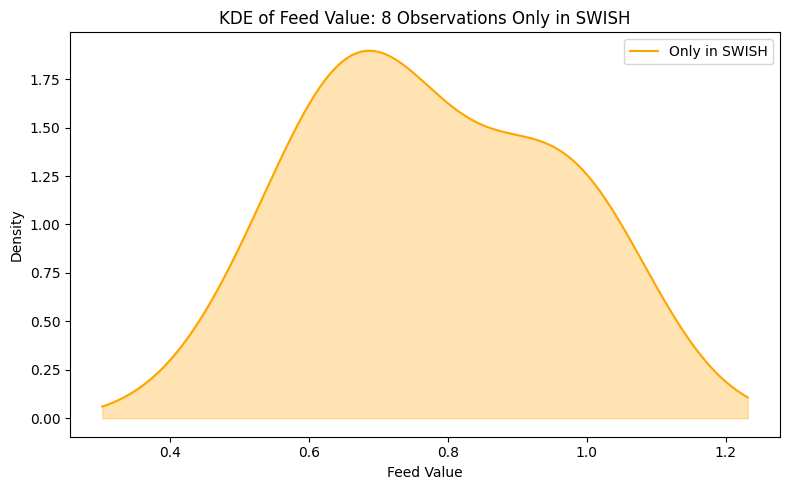

In [20]:
plt.figure(figsize=(8, 5))
if not only_swish.empty:
    ax = only_swish['feed_value_swish'].plot(kind='kde', color='orange', label='Only in SWISH')
    x = ax.get_lines()[-1].get_xdata()
    y = ax.get_lines()[-1].get_ydata()
    plt.fill_between(x, y, color='orange', alpha=0.3)
    plt.xlabel('Feed Value')
    plt.ylabel('Density')
    plt.title('KDE of Feed Value: 8 Observations Only in SWISH')
    plt.legend()
    plt.tight_layout()
    plt.show()

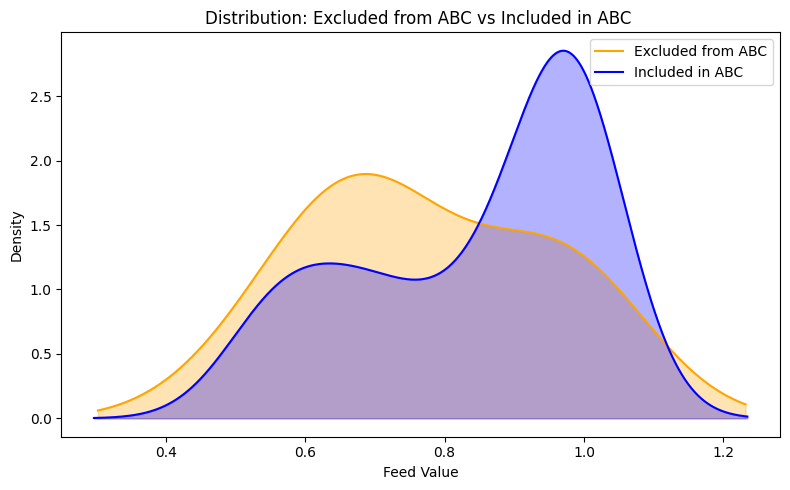

In [29]:
plt.figure(figsize=(8, 5))

# Get entities present in both SWISH and ABC
both_entities = swish['entity'].isin(abc['entity'].unique())
swish_both = swish[both_entities]

# KDE for 8 only in SWISH
if not only_swish.empty:
    ax = only_swish['feed_value_swish'].plot(kind='kde', color='orange', label='Excluded from ABC')
    x = ax.get_lines()[-1].get_xdata()
    y = ax.get_lines()[-1].get_ydata()
    plt.fill_between(x, y, color='orange', alpha=0.3)

# KDE for 50 in both SWISH and ABC
if not swish_both.empty:
    ax2 = swish_both['feed_value_swish'].plot(kind='kde', color='blue', label='Included in ABC', ax=ax)
    x2 = ax2.get_lines()[-1].get_xdata()
    y2 = ax2.get_lines()[-1].get_ydata()
    plt.fill_between(x2, y2, color='blue', alpha=0.3)

plt.xlabel('Feed Value')
plt.ylabel('Density')
plt.title('Distribution: Excluded from ABC vs Included in ABC ')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()